# **Object 7:-**
WAP to retrain a pretrained imagenet model to classify a medical image dataset.


---



# **Description of the Model :-**
In this project, we use transfer learning with the VGG16 model to classify CT scan images as either COVID or Non-COVID. The dataset is organized into two folders, and the images are split into training and validation sets with an 80-20 ratio. To enhance the model's generalization, data augmentation techniques such as resizing, flipping, and rotation are applied.

Most of the original VGG16 layers are frozen to retain the pre-trained features, with only the last convolutional block (layers 24 to 30) being fine-tuned. A custom classifier is added to the model to perform binary classification using a sigmoid activation function.

The model is trained for 20 epochs, using the Binary Cross Entropy Loss function and optimized with the Adam optimizer. Throughout the training, both training and validation accuracy, as well as loss, are tracked. After training, the model is saved for future use, and its performance is visualized using plots. Finally, the accuracy on the validation set is reported. This approach allows for efficient and reliable medical image classification, even with a relatively small dataset.


---



# **Description about the code:-**
**1.Libraries and Hyperparameters:** The script starts by importing essential libraries such as torch, torchvision, and matplotlib for deep learning, image processing, and plotting. It then defines key hyperparameters, including image size, batch size, the number of epochs, and the learning rate. The script also selects the computation device, using a GPU if available; otherwise, it falls back to the CPU.

**2.Data Transformations:** To prepare the dataset, two types of image transformations are applied. The training data undergoes augmentation with resizing, random horizontal flips, and rotations to help the model generalize better. Both the training and validation data are normalized to match the input format expected by the pre-trained VGG16 model, using the ImageNet mean and standard deviation.

**3.Dataset Loading and Splitting:** The dataset is loaded from a folder structure, where each subfolder represents a class (CT_COVID and CT_NonCOVID). The entire dataset is split into training and validation sets, with 80% of the data used for training and 20% for validation. The data is fed in batches using a data loader, with shuffling enabled for the training data to ensure randomness.

**4.Model Setup: VGG16:** A pre-trained VGG16 model is loaded, allowing the model to use features it has already learned from ImageNet. Initially, all layers are frozen to preserve these learned features, except for the last convolutional block (layers 24 to 30), which is unfrozen for fine-tuning. This allows the model to adjust slightly to the new dataset while retaining most of its pre-trained knowledge.

**5.Custom Classifier Design:** The original classifier in VGG16 is replaced with a custom fully connected network designed for binary classification. This new classifier consists of several Linear layers, ReLU activations, and Dropout layers, with the final output being a single neuron that uses a Sigmoid activation function. The Sigmoid output gives a probability between 0 and 1, indicating whether the image is COVID or Non-COVID.

**6.Loss Function and Optimizer:** Binary Cross Entropy Loss is used as the loss function, which is ideal for binary classification. The Adam optimizer is chosen for its efficiency and ability to adapt the learning rate. Only the parameters that require gradients (the unfrozen layers and custom classifier) are passed to the optimizer.

**7.Training Loop:** The model is trained for 20 epochs. During each epoch, the model performs a forward pass, computes the loss, backpropagates the error, and updates the weights. Training loss and accuracy are recorded after each epoch, and the model is also evaluated on the validation set to track its performance on unseen data.

**8.Validation and Metric Tracking:** During validation, the model is set to evaluation mode to prevent updates to dropout layers and batch normalization. Accuracy and loss are calculated without updating the weights, helping to monitor if the model is overfitting or improving its generalization. All metrics are stored for future visualization.

**9.Saving and Plotting Results:** After training is complete, the model is saved for future use. The training and validation accuracy and loss trends are plotted using matplotlib to visualize the model’s performance across the epochs.

**10.Final Evaluation:** Finally, the model is evaluated one last time on the validation set to report its accuracy. This provides a clear measure of how well the trained model generalizes to new CT scan images, and the result is printed for quick assessment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
base_dir = '/content/drive/MyDrive/covid_noncovid'
img_size = 224
batch_size = 32
epochs = 20
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Transforms (simulating ImageDataGenerator)
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load Datasets
train_dataset = datasets.ImageFolder(os.path.join(base_dir), transform=train_transforms)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Load VGG16 model
base_model = models.vgg16(pretrained=True)

# Freeze all layers
for param in base_model.features.parameters():
    param.requires_grad = False

# Optionally unfreeze last convolutional block
for param in base_model.features[24:].parameters():
    param.requires_grad = True

    #Modified the classifier to match Keras structure
base_model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

model = base_model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Training Loop
train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # BCELoss expects float

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Final Evaluation on Validation (Test) Set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"\n Final Test Accuracy on Validation Set: {test_acc:.4f}")

# Save model
torch.save(model.state_dict(), 'covid_classifier_vgg16.pt')

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()




Epoch 1/20 - Train Loss: 0.6703, Train Acc: 0.5785, Val Loss: 0.5717, Val Acc: 0.7285

Epoch 2/20 - Train Loss: 0.5504, Train Acc: 0.7041, Val Loss: 0.4385, Val Acc: 0.8278

Epoch 3/20 - Train Loss: 0.4410, Train Acc: 0.7950, Val Loss: 0.4080, Val Acc: 0.8344

Epoch 4/20 - Train Loss: 0.3681, Train Acc: 0.8512, Val Loss: 0.3338, Val Acc: 0.8742

Epoch 5/20 - Train Loss: 0.2761, Train Acc: 0.8926, Val Loss: 0.2918, Val Acc: 0.8742

Epoch 6/20 - Train Loss: 0.2357, Train Acc: 0.9074, Val Loss: 0.4887, Val Acc: 0.8278

Epoch 7/20 - Train Loss: 0.2232, Train Acc: 0.9058, Val Loss: 0.3057, Val Acc: 0.8675

Epoch 8/20 - Train Loss: 0.1242, Train Acc: 0.9554, Val Loss: 0.2968, Val Acc: 0.8808

Epoch 9/20 - Train Loss: 0.1867, Train Acc: 0.9372, Val Loss: 0.3465, Val Acc: 0.8609

Epoch 10/20 - Train Loss: 0.1694, Train Acc: 0.9438, Val Loss: 0.3482, Val Acc: 0.8675

Epoch 11/20 - Train Loss: 0.0973, Train Acc: 0.9669, Val Loss: 0.3115, Val Acc: 0.8874

Epoch 12/20 - Train Loss: 0.0729, Train Acc: 0.9669, Val Loss: 0.3569, Val Acc: 0.8808

Epoch 13/20 - Train Loss: 0.0850, Train Acc: 0.9769, Val Loss: 0.2531, Val Acc: 0.8940

Epoch 14/20 - Train Loss: 0.0764, Train Acc: 0.9719, Val Loss: 0.3574, Val Acc: 0.8874

Epoch 15/20 - Train Loss: 0.0501, Train Acc: 0.9835, Val Loss: 0.2699, Val Acc: 0.8940

Epoch 16/20 - Train Loss: 0.0273, Train Acc: 0.9934, Val Loss: 0.4222, Val Acc: 0.8742

Epoch 17/20 - Train Loss: 0.0416, Train Acc: 0.9868, Val Loss: 0.4793, Val Acc: 0.8808

Epoch 18/20 - Train Loss: 0.0302, Train Acc: 0.9967, Val Loss: 0.3842, Val Acc: 0.9007

Epoch 19/20 - Train Loss: 0.0341, Train Acc: 0.9801, Val Loss: 0.3397, Val Acc: 0.8808

Epoch 20/20 - Train Loss: 0.0408, Train Acc: 0.9752, Val Loss: 0.3016, Val Acc: 0.9039

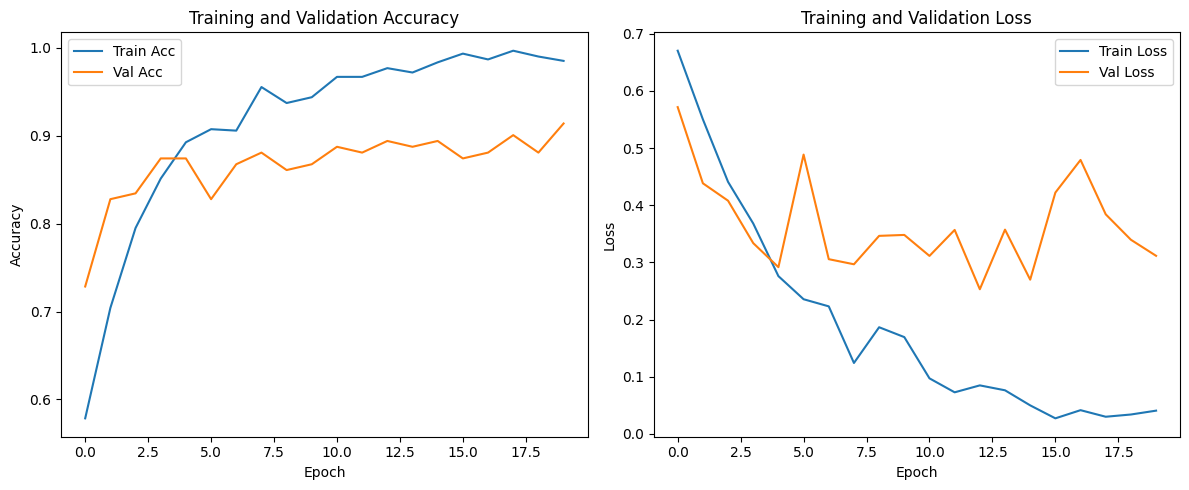

# **My Comments :-**

Overfitting Risk: High training accuracy and lower validation accuracy may suggest overfitting. Use of regularization (dropout) is a can be useful.

Model Complexity: Using of some samller models like EfficientNet might provide comparable accuracy with reduced computational cost.

Binary Loss Function: While BCELoss is standard, switching to BCEWithLogitsLoss (and removing sigmoid) can offer better numerical stability.

Data Size: Increasing dataset size can significantly improve performance.
Getting accuracy approx 90% .